In [7]:
#############
# CHAPTER 3 #
#############

In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

X, y = mnist["data"], mnist["target"]

# fetch_mldata was deprecated in v0.20
print(X)
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

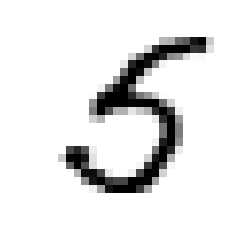

'5'

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3859]
some_digit_image = some_digit.reshape(28, 28)

# imshow == 'image show'
# cmap   == color map (binary == b/w)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')

plt.show()
y[3859]

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
import numpy as np

shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index].astype('int'), y_train[shuffle_index].astype('int')

# needed to convert data from string to int

In [14]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)



In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
# 0.96265
# 0.96384
# 0.94982

0.9211039448027598
0.9666241656041401
0.9652741318532964


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.92110394, 0.96662417, 0.96527413])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


# 0.91105445
# 0.91059776
# 0.90714768
#
# Because only 10% of the images are 5s,
# you can always guess that an image is _not_ a 5 
# and still be right 90% of the time
#
# This demonstrates why accuracy is generally
# not the preferred performance measure for classifiers


array([0.9100045 , 0.90767269, 0.9120228 ])

In [21]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3)


In [22]:
print(y_train_pred)
print(y_train_score)

[False False False ... False False  True]
[0.92110394 0.96662417 0.96527413]


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[35082,  1314],
       [  646,  2958]])

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# When model says something is a 5, it is only right 77.6% of the time 

0.6924157303370787

In [25]:
recall_score(y_train_5, y_train_pred)
# Model only detects 76% of the 5s in a dataset

0.8207547169811321

In [26]:
# F1 score is the "harmonic mean" of precisoni and recall
# Mean treats all values equally, harmonic mean gives more weight to low values
# Classifier will only get high F1 score if both precision and recall are high
#
# F1 score == 2 / ((1 / precision) + (1 / recall))
#
# 2 * ((precision * recall) / (precision + recall))


from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7511427120365669

In [27]:
# Precision/Recall tradeoff => you can either have
#
# ALL of the positive instances (with some false positives), e.g. shoplifter alarm system
# or
# 
# ONLY positive instances (with false negatives), e.g. filtering content on childrens videos

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5547.96534715])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-18764.78389854, -20136.57799235,  -7066.69808911, ...,
       -29617.41244648, -16397.4720912 ,  16789.20508391])

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print('precision:', precisions)
print('\n')
print('recalls:', recalls)
print('\n')
print('thresholds:', thresholds)

precision: [0.09043007 0.09040725 0.09040952 ... 1.         1.         1.        ]


recalls: [1.00000000e+00 9.99722531e-01 9.99722531e-01 ... 5.54938957e-04
 2.77469478e-04 0.00000000e+00]


thresholds: [-128319.0353851  -128139.65367456 -128011.24780215 ...   71440.39213713
   72150.8368222    79761.74654082]


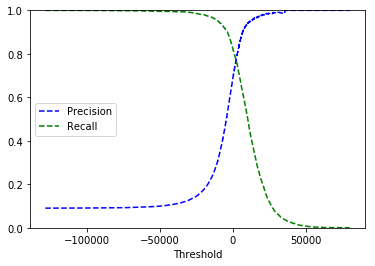

In [33]:
def plot_precision_recall_vs_threshold(precisions ,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [34]:
y_train_pred_90 = (y_scores > 5000)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.8626412429378532

In [36]:
recall_score(y_train_5, y_train_pred_90, average='weighted')

0.96125

In [37]:
# Receiver Operating Characteristic (ROC)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

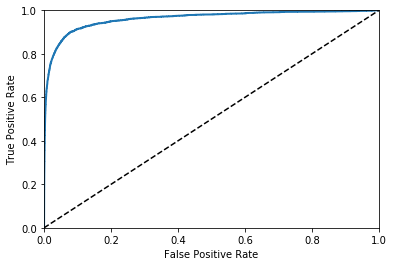

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.961535980341536

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


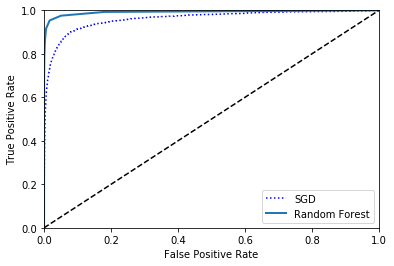

In [41]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921314997049961

In [43]:
y_train_forest_pred = (y_scores_forest > 0.5)


precision_score(y_train_5, y_train_forest_pred)


0.988279903481558

In [44]:
y_train_forest_pred = (y_scores_forest > 0.5)

recall_score(y_train_5, y_train_forest_pred)

0.7955049944506104

In [45]:
#############################
# Multiclass Classification #
#############################

# OvA => One vs All =>
#    train 10 binary classifiers (y_train_1, y_train_2, etc...)
#    select the class whose classifier outputs the highest score

# OvO => One vs One =>
#    classifier to determine (1 vs 2), (2 vs 3), (3 vs 4), etc...

# OvO requires N * (N-1) / 2 classifiers (9 + 8 + 7 + 6...)

# OvO only needs to be trained on part of the dataset (the part with the two competing values)
# OvO is preferred for algorithms that scale poorly with the size of the data set (e.g. SVM)
# It is faster to train many of these classifiers on small training sets than training few classifiers on large training sets

# OvA scales better when classes are larger, since it only runs N times through the dataset
# OvA is preferred for most binary classification algorithms



In [46]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5])

In [47]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -15444.08322355, -114353.02582891,  -18908.06849293,
          -7433.65920428,  -14404.74197654,    5547.96534715,
         -17335.39566373,  -44167.14011833,   -7165.10422487,
         -28918.3403364 ]])

In [48]:
np.argmax(some_digit_scores)

5

In [49]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
idx = np.argmax(some_digit_scores)
sgd_clf.classes_[idx]

5

In [51]:
######################
# OneVsOneClassifier #
######################
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1500, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5])

In [52]:
len(ovo_clf.estimators_)

45

In [53]:
##########################
# RandomForestClassifier #
##########################

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5])

In [54]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [55]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8830234 , 0.87287182, 0.87135249])

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90664367, 0.90279757, 0.89588178])

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [58]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3714,    0,   12,    2,    5,   40,   30,    3,  118,    0],
       [   1, 4337,   30,   21,    3,   33,    4,    5,  119,   10],
       [  17,   18, 3443,   71,   54,   19,   54,   25,  235,    7],
       [  17,   17,   84, 3518,    1,  128,   14,   38,  220,   44],
       [  10,   11,   35,    9, 3499,    8,   31,   16,  172,  118],
       [  20,   15,   27,  102,   40, 3006,   47,   12,  277,   58],
       [  22,   14,   34,    1,   34,   64, 3714,    5,   86,    1],
       [  12,    8,   37,   21,   34,    5,    4, 3769,   80,  155],
       [   8,   36,   35,   62,    2,   81,   29,    5, 3568,   34],
       [  19,   16,   26,   43,   75,   17,    2,  121,  194, 3503]])

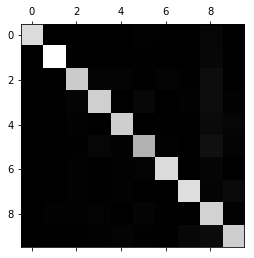

In [59]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

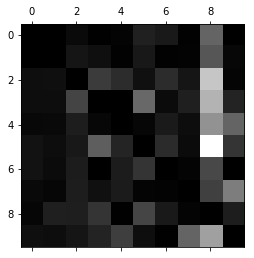

In [61]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [62]:
# The `plot_digits()` function is really uninteresting,
# it just plots an image using Matplotlib. I preferred to leave it out of the book
# to avoid drowning the reader in minor details. However, I agree that I should have added a note about it,
# for clarity. I just added the following note:

# "(the `plot_digits()` function just uses Matplotlib's `imshow()` function, 
# see this chapter's Jupyter notebook for details)"

In [63]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

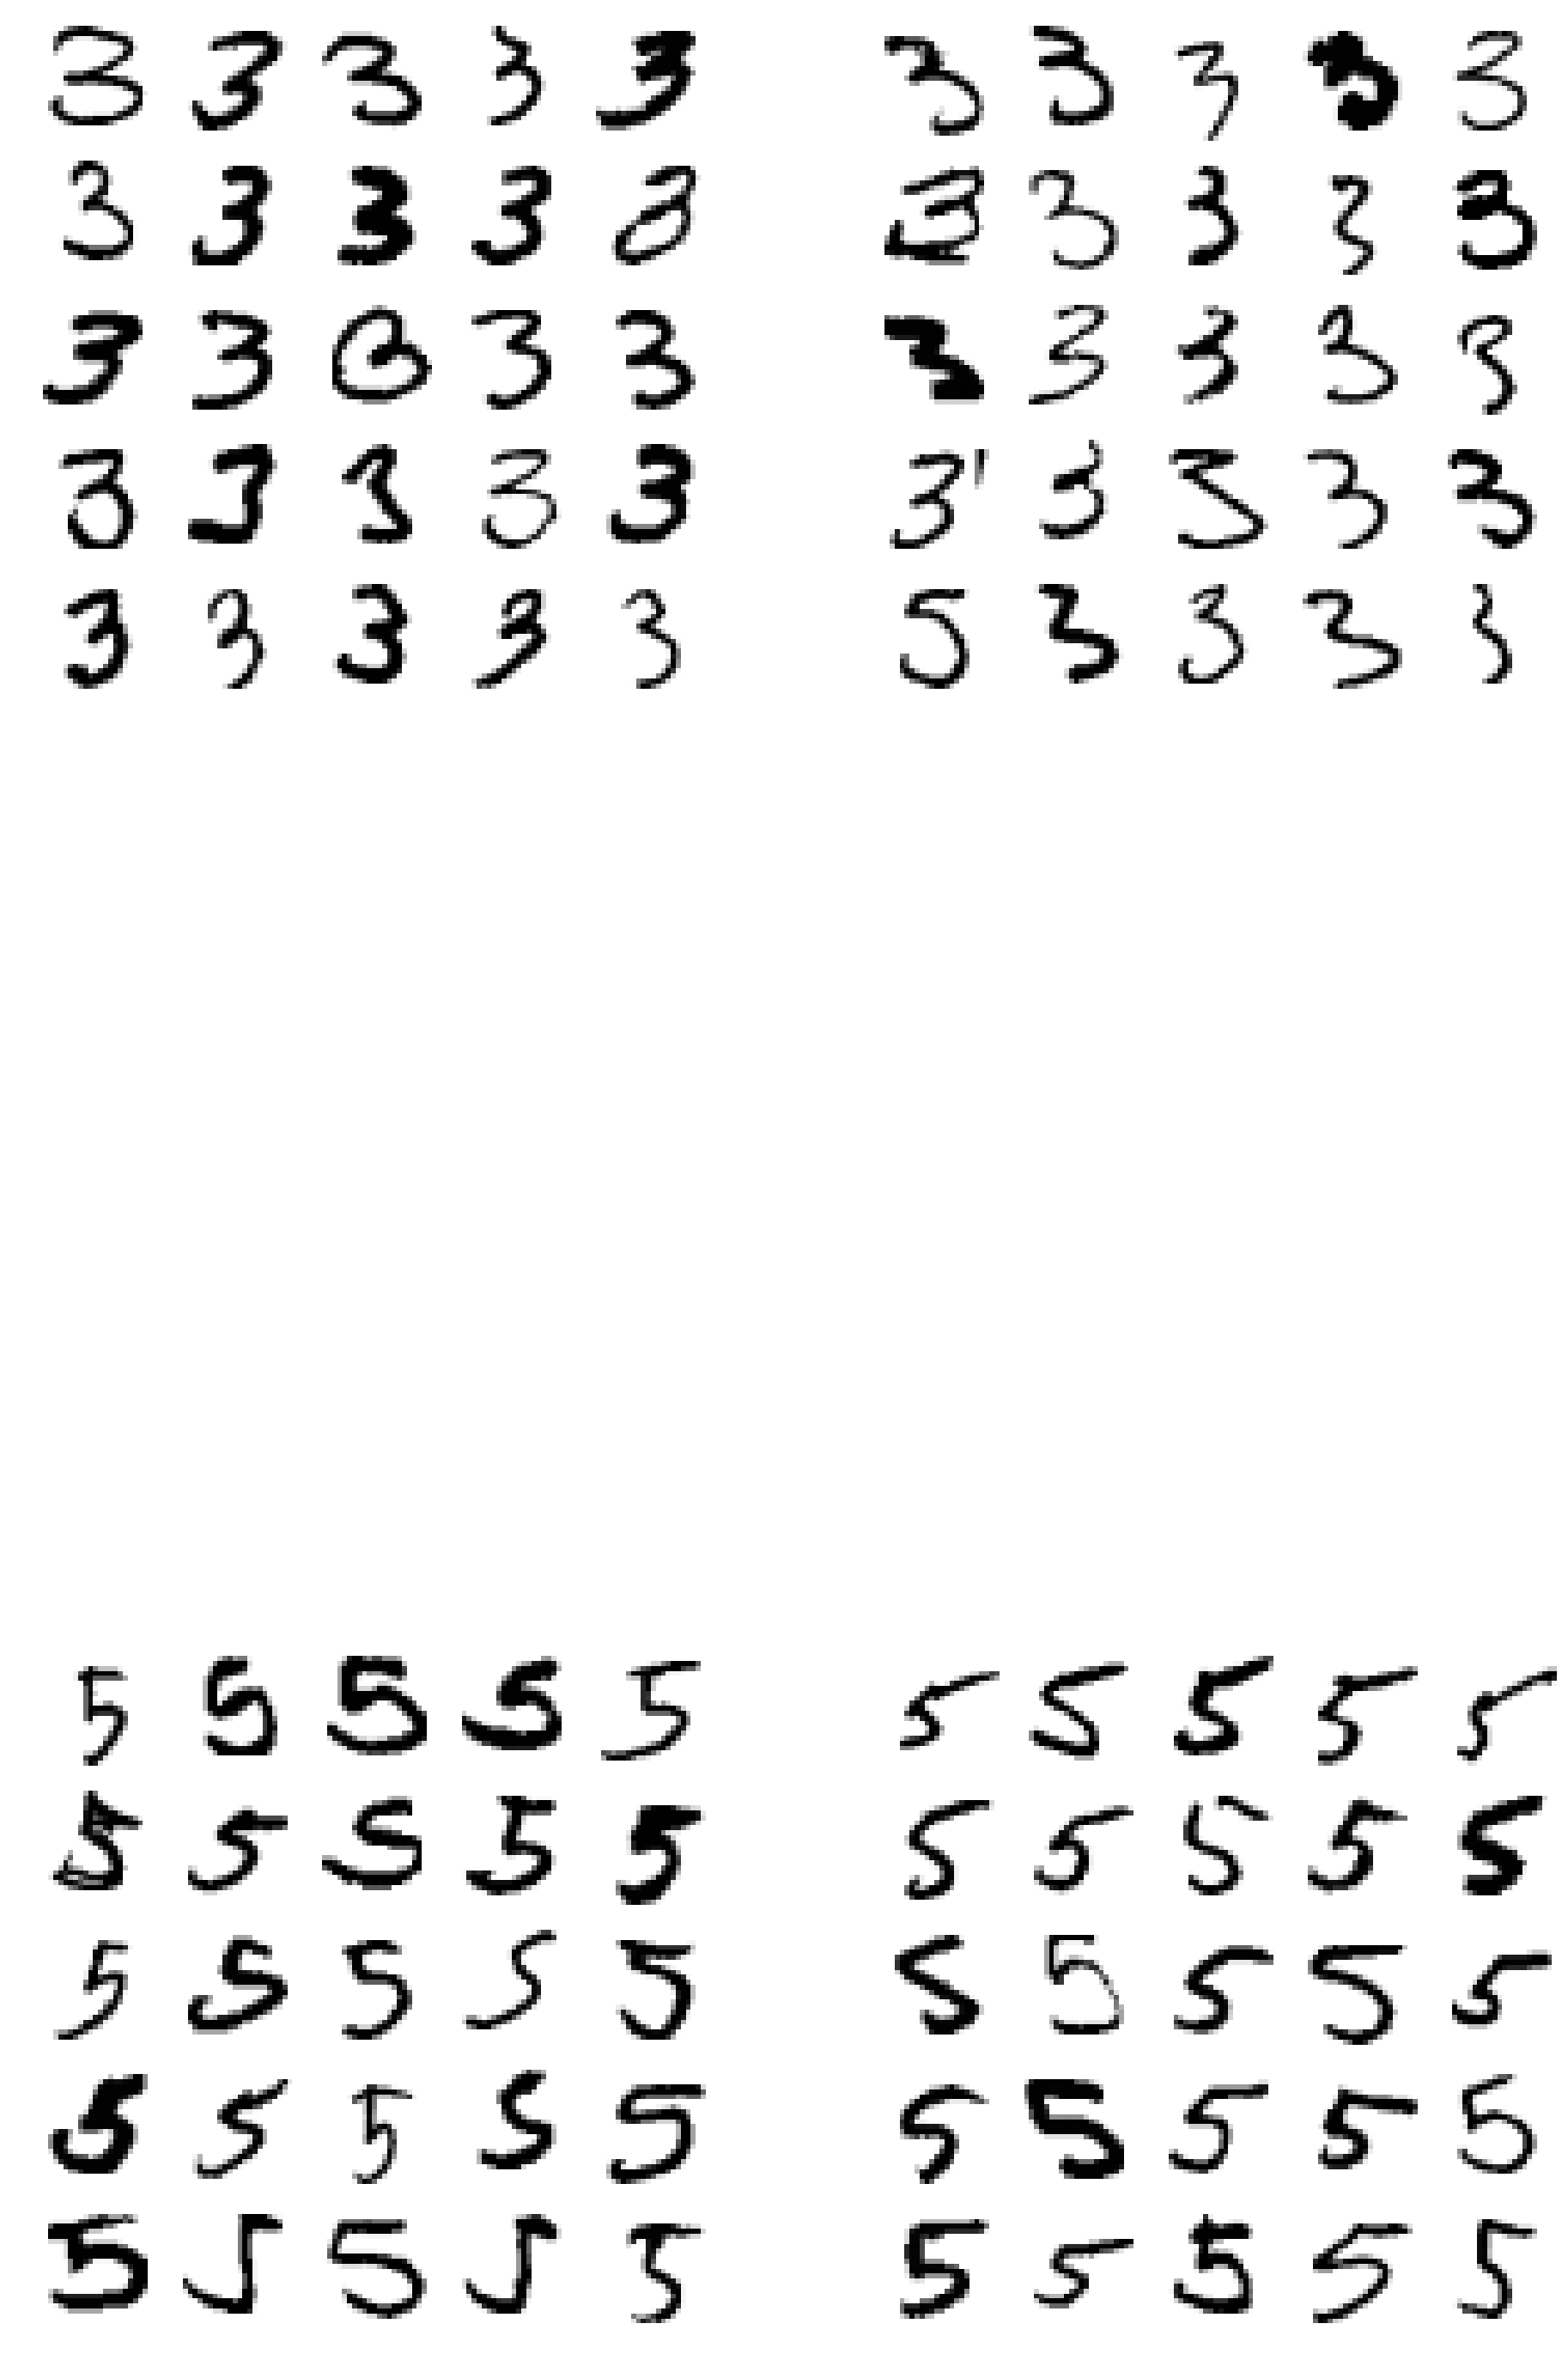

In [64]:

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(32, 64))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9637730520850013

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [70]:
some_index = 1478

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [72]:
print(clean_digit)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0  13 186  13   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   9 254 254   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 254 254   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  52 254 110   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0 254 254   8   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  98 254 122   0   0 

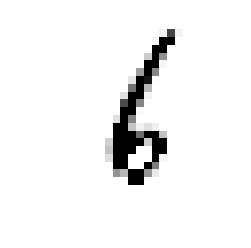

In [73]:
plot_digits(clean_digit)